In [1]:
from jax_md import *
import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt

# jax.config.update("jax_enable_x64", True)

In [2]:
dim = 2
N = 256
box_size = quantity.box_size_at_number_density(N, 1, dim)

In [3]:
displacement, shift = space.periodic(box_size)
metric = space.metric(displacement)
v_displacement = space.map_product(displacement)
v_metric = space.map_product(metric)

My way of doing a brownian simulation, and saving the state at every timestep

In [4]:
def brownian_simulation(key, temperature, dt, steps, energy_fn):
    pos_key, sim_key, times_key = jr.split(key, 3)
    R = jr.uniform(pos_key, (N, 2), maxval=box_size)
    #R = jnp.zeros((N, 2))

    init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt, temperature)
    initial_state = init_fn(sim_key, R)
    state = init_fn(sim_key, R)

    do_step = lambda state, t: (apply_fn(state), apply_fn(state))
    final_state, intermediate_states = jax.lax.scan(do_step, state, steps)

    return initial_state.position, final_state.position, intermediate_states.position, times_key

In [5]:
initial, final, intermediate, times_key = brownian_simulation(jr.PRNGKey(0), 0.05, 0.01, jnp.arange(1000), lambda r: 0.)

In [6]:
final = jnp.expand_dims(final, 0)
initial = jnp.expand_dims(initial, 0)
all_states = jnp.concatenate((initial, intermediate, final), axis=0)
print(jnp.shape(all_states))

(1002, 256, 2)


In [7]:
correction = 0.5*box_size*jnp.ones_like(all_states)

In [8]:
all_states = all_states - correction

In [9]:
@jax.vmap
def compute_norm(positions):
    return jnp.sqrt(positions[:, 0]**2 + positions[:, 1]**2)

In [10]:
norms = compute_norm(all_states)

In [11]:
print(jnp.shape(norms))

(1002, 256)


In [12]:
dr = box_size/1000
rr = jnp.arange(dr, box_size+dr, dr)
def compute_g_quick(norms, length):
    # set zeros to length+1 so bincount ignores 
    bins = jnp.floor(norms/dr).astype(int)
    return jnp.bincount(bins.flatten(), length=length)
compute_g_quick = jax.vmap(compute_g_quick, in_axes=(0, None))

In [13]:
g_test = compute_g_quick(norms, 1000)

In [14]:
print(jnp.shape(g_test))

(1002, 1000)


In [15]:
normalisation = jnp.roll(2*jnp.pi*rr*dr, 1)
normalisation = normalisation.at[0].set(jnp.pi*dr*dr)

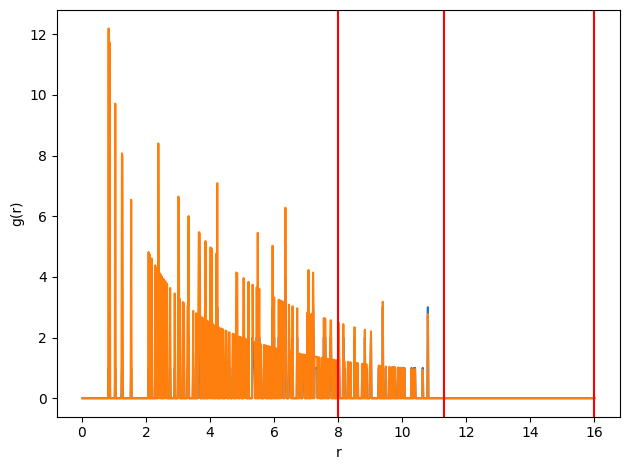

In [18]:
plt.plot(rr, g_test[0, :])
plt.plot(rr, g_test[0, :]/normalisation)
plt.axvline(box_size/2, color="red")
plt.axvline(box_size/jnp.sqrt(2), color="red")
plt.axvline(box_size, color="red")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.tight_layout()
plt.show()

In [20]:
def brownian_simulation_vec(key, temperature, dt, steps, energy_fn):
    pos_key, sim_key, times_key = jr.split(key, 3)
    R = jr.uniform(pos_key, (N, 2), maxval=box_size)
    #R = jnp.zeros((N, 2))

    init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt, temperature)
    initial_state = init_fn(sim_key, R)
    state = init_fn(sim_key, R)

    do_step = lambda state, t: (apply_fn(state), apply_fn(state))
    final_state, intermediate_states = jax.lax.scan(do_step, state, steps)

    initial = initial_state.position
    intermediate = intermediate_states.position
    final = final_state.position

    final = jnp.expand_dims(final, 0)
    initial = jnp.expand_dims(initial, 0)

    all_states = jnp.concatenate((initial, intermediate, final), axis=0)

    return all_states, times_key

brownian_simulation_vec = jax.vmap(brownian_simulation_vec, in_axes=(0, None, None, None, None))

In [21]:
keys = jr.split(jr.PRNGKey(0), 1000)

In [22]:
states, time_keys = brownian_simulation_vec(keys,  0.05, 0.01, jnp.arange(1000), lambda r: 0.)

In [23]:
print(jnp.shape(states))

(1000, 1002, 256, 2)


In [24]:
def apply_correction(states, correction):
    return states-correction
apply_correction_vec = jax.vmap(apply_correction, in_axes=(0, None))

In [25]:
correction = 0.5*box_size*jnp.ones_like(states[0, :, :, :])
print(jnp.shape(correction))

(1002, 256, 2)


In [26]:
states_corrected = apply_correction(states, correction)

In [27]:
print(jnp.shape(states_corrected))

(1000, 1002, 256, 2)


In [28]:
@jax.vmap
def compute_more_norms(states):
    @jax.vmap
    def compute_norm(positions):
        return jnp.sqrt(positions[:, 0]**2 + positions[:, 1]**2)
    return compute_norm(states)

In [29]:
all_norms = compute_more_norms(states_corrected)

In [30]:
print(jnp.shape(all_norms))

(1000, 1002, 256)


In [31]:
norm_final = all_norms[:, -1, :]

In [35]:
print(jnp.shape(norm_final))

(1000, 256)


In [32]:
dr = box_size/1000
rr = jnp.arange(dr, box_size+dr, dr)
def compute_g_quick(norms, length):
    # set zeros to length+1 so bincount ignores 
    bins = jnp.floor(norms/dr).astype(int)
    return jnp.bincount(bins.flatten(), length=length)
compute_g_quick_vec = jax.vmap(compute_g_quick, in_axes=(0, None))

In [44]:
all_rdfs = compute_g_quick_vec(all_norms, 1000)
rdf_final = compute_g_quick_vec(norm_final, 1000)

In [45]:
print(jnp.shape(all_rdfs))
print(jnp.shape(rdf_final))

(1000, 1000)
(1000, 1000)


In [46]:
rdf_avg = jnp.mean(all_rdfs, axis=0)
rdf_avg_final = jnp.mean(rdf_final, axis=0)

In [48]:
normalisation = jnp.roll(2*jnp.pi*rr*dr, 1)
normalisation = normalisation.at[0].set(jnp.pi*dr*dr)

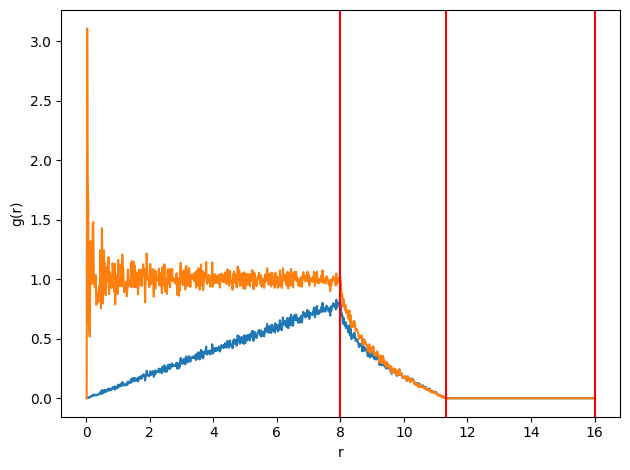

In [49]:
plt.plot(rr, rdf_avg_final)
plt.plot(rr, rdf_avg_final/normalisation)
plt.axvline(box_size/2, color="red")
plt.axvline(box_size/jnp.sqrt(2), color="red")
plt.axvline(box_size, color="red")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.tight_layout()
# plt.savefig("2d_bm_torus_initial_uniform_first_density_rdf", dpi=300)
plt.show()